In [1]:
addpath(genpath('../../../../src'))

# Finding ground states of local Hamiltonians

This notebook demonstrates how to find the ground state of local one-dimensional Hamiltonians with MPS methods, using the `Tensor` backend. It utilizes the functionalities defined in the notebook on uniform MPS (which should therefore be run before this notebook). Our discussion is based on the fourth and sixth chapters of the [lecture notes on tangent space methods for uniform MPS](https://doi.org/10.21468/SciPostPhysLectNotes.7) by Laurens Vanderstraeten, Jutho Haegeman and Frank Verstraete.

The contents of this notebook mirror that of a tutorial given at the [2020 school on Tensor Network based approaches to Quantum Many-Body Systems](http://quantumtensor.pks.mpg.de/index.php/schools/2020-school/) held in Bad Honnef, Germany, which can be found [here](https://github.com/leburgel/BadHonnefTutorial).

## 1 Introduction

In the notebook on uniform MPS, we stated that these states ccan be used to efficiently approximate low-energy states of one-dimensional systems with gapped local Hamiltonians. Having defined ways of representing and manipulating MPS, the logical next step is therefore to have a look at how exactly they can be used to find ground states. To this end, we consider a nearest-neighbour Hamiltonian $H$  of the form

$$H = \sum_n h_{n, n+1}$$

acting on an infinite one-dimensional system. Here, $h_{n,n+1}$ is a hermitian operator acting non-trivially on sites $n$ and $n+1$. As in any variational approach, the variational principle serves as a guide for finding ground-state approximations, dictating that the optimal MPS approximation of the ground state corresponds to the minimum of the expectation value of the energy,

$$ \min_A \frac{\left \langle \Psi(\bar{A}) \middle | H  \middle | \Psi(A) \right \rangle}{\left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle}. $$

In the thermodynamic limit the energy diverges with system size, but, since we are working with translation-invariant states only, we should rather minimize the energy density. In the following we will always restrict our discussion to preoperly normalized states. Diagrammatically, the minimization problem can then be recast as

<center><img src="img/2minham.svg" alt="minimization of hamiltonian"></center>

In this notebook we illustratre numerical optimization strategies for minimizing this energy density directly.

## 2 The gradient

Any optimization problem relies on an efficient evaluation of the gradient, so the first thing to do is to compute this quantity. The objective function $f$ that we want to minimize is a real function of the complex-valued $A$, or equivalently, of the independent variables $A$ and $\bar{A}$. The gradient $g$ is then obtained by differentiating $f(\bar{A},A)$ with respect to $\bar{A}$,

$$
\begin{align}
g &= 2 \times \frac{\partial f(\bar{A},A) }{ \partial \bar{A} } \\
&= 2\times \frac{\partial_{\bar{A}} \left \langle \Psi(\bar{A}) \middle | h  \middle | \Psi(A) \right \rangle } {\left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle} - 2\times \frac{\left \langle \Psi(\bar{A}) \middle | h  \middle | \Psi(A) \right \rangle} {\left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle^2} \partial_{\bar{A}} \left \langle \Psi(\bar{A}) \middle | \Psi(A) \right \rangle ,\\
&= 2\times \frac{\partial_{\bar{A}}  \left \langle \Psi(\bar{A}) \middle | h  \middle | \Psi(A) \right \rangle - e \partial_{\bar{A}} \left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle  } {\left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle},\\
\end{align}
$$

where we have clearly indicated $A$ and $\bar{A}$ as independent variables and $e$ is the current energy density given by

$$
e = \frac{\left \langle \Psi(\bar{A}) \middle | h  \middle | \Psi(A) \right \rangle} {\left \langle \Psi(\bar{A}) \middle | \Psi(A)  \right \rangle}.
$$

If we make sure that the MPS is properly normalized and subtract the current energy density from every term in the hamiltonian, $h \leftarrow h - e$, the gradient takes on the simple form

$$ g = 2 \times \partial_{\bar{A}} \left \langle \Psi(\bar{A}) \middle | h  \middle | \Psi(A) \right \rangle.$$

Thus, the gradient is obtained by differentiating the expression

<center><img src="img/grad.svg" alt="gradient"></center>

with respect to $\bar{A}$. This gives rise to a sum over all sites, where in every term we differentiate with respect to one tensor $\bar{A}$ in the bra layer. Differentiating with respect to one $\bar{A}$ tensor amounts to leaving out that tensor, and interpreting the open legs as outgoing ones, i.e. each term looks like

<center><img src="img/gradTerm.svg" alt="gradient term"></center>

The full gradient is then obtained as an infinite sum over these terms. By dividing the terms into three different classes and doing some bookkeeping as illustrated below, we can eventually write this sum in a relatively simple closed form.

### Terms of the 'center' kind
The first kind of terms that arise in the above expression for the gradient are obtained by differentiation with respect to an $\bar{A}$ tensor on the legs of the Hamiltonian operator. This results in two 'center' terms

<center><img src="img/centerTerms.svg" alt="center terms"></center>

In [2]:
%%file gradCenterTerms.m
function [term1, term2] = gradCenterTerms(hTilde, A, l, r)
    % Calculate the value of the center terms.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % A : :class:`Tensor` (D, d, D)
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % term1 : :class:`Tensor` (D, d, D)
    %     first term of gradient,
    %     ordered left-mid-right.
    % term2 : :class:`Tensor` (D, d, D)
    %     second term of gradient,
    %     ordered left-mid-right.
    
    arguments
        hTilde
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    term1 = contract(l, [-1, 1], r, [5, 7], A, [1, 3, 2], A, [2, 4, 5], conj(A), [-3, 6, 7], hTilde, [3, 4, -2, 6]);
    
    term2 = contract(l, [6, 1], r, [5, -3], A, [1, 3, 2], A, [2, 4, 5], conj(A), [6, 7, -1], hTilde, [3, 4, 7, -2]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/gradCenterTerms.m'.


### Terms of the 'left' kind
For the terms where we leave out an $\bar{A}$ tensor to the left of $h$, which we will call 'left' terms, we can contract everything to the left of this missing $\bar{A}$ with the left fixed point $l$, while everything to the right of $h$ can be contracted with right fixed point $r$.

In between these two outer parts of the network there remains a region where the regular MPS transfer matrix $E$ is applied a number of times. The action of this region is therefore captured by the operator $E^n$, where the power $n$ is determined by the seperation between the outer left and right parts for the specific term under consideration. When summing all left terms, the outer parts of the contraction always remain the same, while only the power $n$ differs for every term. Thus, summing all left terms corresponds to contracting the operator 

$$E_\text{sum} = 1 + E + E^2 + \dots = \frac{1}{1-E}$$

between the left and right outer parts. Here, we have naively used the geometric series to write the sum in a closed form. However, since by our normalization the transfer matrix has leading eigenvalue $1$, this resulting expression will diverge and is therefore ill-defined. We can get around this by introducing a regularized transfer matrix $\tilde{E}$ which is defined by subtracting the divergent part,

<center><img src="img/regTransfer.svg" alt="regularized transfer matrix"></center>

Since we have already shifted the energy density to have a zero expectation value, $h \leftarrow h - e$, it can easily be verified that the contribution of the leading divergent part vanishes in every left term, meaning that we can simply replace the original transfer matrix by its regularized version without changing any of the terms, and only then take the infinite sum which now has a well defined expression in terms of an inverse,

$$ E_\text{sum} \rightarrow \frac{1}{1-\tilde{E}} \equiv (1 - E)^P ,$$

where we have introduced the pseudo-inverse defined as $(1 - E)^P = (1-\tilde{E})^{-1}$.

Using this notation we can define the partial contraction

<center><img src="img/Rh.svg" alt="right effective environment"></center>

such that the sum of all left terms equals

<center><img src="img/leftTerms.svg" alt="left terms"></center>


If we would compute the partial contraction $R_h$ directly by explicitly computing the pseudo-inverse, this would entail a computational complexity $O(D^6)$. Instead, we can define $L_h$ as the solution of a linear problem by multiplying both sides of the corresponding definition by $(1-\tilde{E})$. This results in an equation of the form $Ax = b$ which may be solved for $x$ by using Krylov-based iterative methods such as those implemented in `Tensor.linsolve`.  Note that these methods only require the action of $A = (1-\tilde{E})$ on a vector and not the full matrix $A$. This action can again be supplied to the linear solver using a function handle.

In [3]:
%%file reducedHamUniform.m
function hTilde = reducedHamUniform(h, A, l, r)
    % Regularize Hamiltonian such that its expectation value is 0.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian that needs to be reduced,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % A : :class:`Tensor` (D, d, D)
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    
    arguments
        h
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    % calculate expectation value
    e = real(expVal2Uniform(h, A, l, r));
    
    % substract from hamiltonian
    I = h.eye(h.dims([1, 1]), 'Rank', [1, 1]);
    hTilde = h - e * contract(I, [-1, -3], I, [-2, -4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/reducedHamUniform.m'.


In [4]:
%%file EtildeRight.m
function vNew = EtildeRight(v, A, l, r)
    % Implement the action of (1 - Etilde) on a right vector v.
    %
    % Parameters
    % ----------
    % v : :class:`Tensor` (D, D)
    %     right matrix on which
    %     (1 - Etilde) acts
    % A : :class:`Tensor` (D, d, D)
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D)
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D)
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % vNew : :class:`Tensor` (D, D)
    %     result of action of (1 - Etilde)
    %     on a right matrix
    
    % interpret input as matrix
    v = repartition(v, [1, 1]);
    
    % transfermatrix contribution
    transfer = contract(A, [-1, 2, 1], conj(A), [-2, 2, 3], v, [1, 3], 'Rank', [1, 1]);

    % fixed point contribution
    fixed = trace(l * v) * r;

    % sum these with the contribution of the identity
    vNew = v - transfer + fixed;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/EtildeRight.m'.


In [5]:
%%file RhUniform.m
function Rh = RhUniform(hTilde, A, l, r)
    % Find the partial contraction for Rh.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % A : :class:`Tensor` (D, d, D)
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % Rh : :class:`Tensor` (D, D)
    %     result of contraction,
    %     ordered top-bottom.
    
    arguments
        hTilde
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    % construct b, which is the matrix to the right of (1 - E)^P in the figure above
    b = contract(r, [4, 5], A, [-1, 2, 1], A, [1, 3, 4], conj(A), [-2, 8, 7], conj(A), [7, 6, 5], hTilde, [2, 3, 8, 6], 'Rank', [1, 1]);
    
    % solve Ax = b for x
    [Rh, ~] = linsolve(@(v) EtildeRight(v, A, l, r), b);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/RhUniform.m'.


In [6]:
%%file gradLeftTerms.m
function leftTerms = gradLeftTerms(hTilde, A, l, r)
    % Calculate the value of the left terms.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % A : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % leftTerms : :class:`Tensor` (D, d, D)
    %     left terms of gradient,
    %     ordered left-mid-right.
    
    arguments
        hTilde
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    % calculate partial contraction
    Rh = RhUniform(hTilde, A, l, r);
    
    % calculate full contraction
    leftTerms = contract(Rh, [1, -3], A, [2, -2, 1], l, [-1, 2]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/gradLeftTerms.m'.


### Terms of the 'right' kind

In a similar way, the terms where we leave out an $\bar{A}$ to the right of  $h$ can be evaluated by defining the partial contraction

<center><img src="img/Lh.svg" alt="Lh"></center>

which can again be found by solving a linear system, such that the sum of all right terms can be written as

<center><img src="img/rightTerms.svg" alt="rightTerms"></center>

In [7]:
%%file EtildeLeft.m
function vNew = EtildeLeft(v, A, l, r)
    % Implement the action of (1 - Etilde) on a left vector matrix v.
    %
    % Parameters
    % ----------
    % v : :class:`Tensor` (D, D)
    %     right matrix on which
    %     (1 - Etilde) acts
    % A : :class:`Tensor` (D, d, D)
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D)
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D)
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % vNew : :class:`Tensor` (D, D)
    %     result of action of (1 - Etilde)
    %     on a left matrix
    
    % interpret input as matrix
    v = repartition(v, [1, 1]);

    % transfer matrix contribution
    transfer = contract(v, [3, 1], A, [1, 2, -2], conj(A), [3, 2, -1], 'Rank', [1, 1]);

    % fixed point contribution
    fixed = trace(v * r) * l;

    % sum these with the contribution of the identity
    vNew = v - transfer + fixed;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/EtildeLeft.m'.


In [8]:
%%file LhUniform.m
function Lh = LhUniform(hTilde, A, l, r)
    % Find the partial contraction for Lh.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % A : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % Lh : :class:`Tensor` (D, D)
    %     result of contraction,
    %     ordered bottom-top.
    
    arguments
        hTilde
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    % construct b, which is the matrix to the right of (1 - E)^P in the figure above
    b = contract(l, [5, 1], A, [1, 3, 2], A, [2, 4, -2], conj(A), [5, 6, 7], conj(A), [7, 8, -1], hTilde, [3, 4, 6, 8]);
    
    % solve Ax = b for x
    [Lh, ~] = linsolve(@(v) EtildeLeft(v, A, l, r), b);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/LhUniform.m'.


In [9]:
%%file gradRightTerms.m
function rightTerms = gradRightTerms(hTilde, A, l, r)
    % Calculate the value of the right terms.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % A : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % rightTerms : :class:`Tensor` (D, d, D)
    %     right terms of gradient,
    %     ordered left-mid-right.
    
    arguments
        hTilde
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
    
    % calculate partial contraction
    Lh = LhUniform(hTilde, A, l, r);
    
    % calculate full contraction
    rightTerms = contract(Lh, [-1, 1], A, [1, -2, 2], r, [2, -3]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/gradRightTerms.m'.


### The gradient

The full gradient is then found by summing the contributions of all three types of terms,

<center><img src="img/gradFull.svg" alt="gradient"></center>

In [10]:
%%file gradient.m
function grad = gradient(h, A, l, r)
    % Calculate the gradient of the expectation value of h @ MPS A.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % A : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right.
    % l : :class:`Tensor` (D, D), optional
    %     left fixed point of transfermatrix,
    %     normalized.
    % r : :class:`Tensor` (D, D), optional
    %     right fixed point of transfermatrix,
    %     normalized.
    %
    % Returns
    % -------
    % grad : :class:`Tensor` (D, d, D)
    %     gradient,
    %     ordered left-mid-right.
    
    arguments
        h
        A
        l = []
        r = []
    end
    
    % calculate fixed points if not given
    if isempty(l) || isempty(r)
        [l, r] = fixedPoints(A);
    end
        
    % renormalize Hamiltonian
    hTilde = reducedHamUniform(h, A, l, r);
        
    % find terms
    [centerTerm1, centerTerm2] = gradCenterTerms(hTilde, A, l, r);
    leftTerms = gradLeftTerms(hTilde, A, l, r);
    rightTerms = gradRightTerms(hTilde, A, l, r);
    
    grad = 2 * (centerTerm1 + centerTerm2 + leftTerms + rightTerms);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/gradient.m'.


## 3 Gradient descent algorithms

The most straightforward way to use this expression for the gradient to find the ground state of a Hamiltonian is to implement a gradient-search method for minimizing the energy expecation value. The simplest such method is a steepest-descent search, where in every iteration the tensor $A$ is updated in the direction opposite to the gradient along a small step $\varepsilon$,

$$ A_{i+1} = A_i - \varepsilon g .$$

This procedure is repeated until we find the optimal MPS tensor $A^*$ for which the gradient vanishes. This approach can be improved upon by resorting to other optimization schemes such a conjugate-gradient or quasi-Newton methods. Below we demonstrate both a simple steepest-descent with a fixed step size, as well as an approach using Matlab's builtin nonlinear optimization routine `fminunc`.

In [11]:
%%file groundStateGradDescent.m
function [E, A] = groundStateGradDescent(h, D, eps, A0, tol, maxIter)
    % Find the ground state using gradient descent.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian to minimize,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % D : int
    %     bond dimension
    % eps : double, optional
    %     Stepsize.
    % A0 : :class:`Tensor` (D, d, D), optional
    %     normalized MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     initial guess.
    % tol : float, optional
    %     tolerance for convergence criterium.
    % maxIter : int, optional
    %     maximum number of iterations
    %
    % Returns
    % -------
    % E : double
    %     expectation value @ minimum
    % A : :class:`Tensor` (D, d, D)
    %     ground state MPS,
    %     ordered left-mid-right.
    
    arguments
        h
        D
        eps = 1e-1
        A0 = []
        tol = 1e-4
        maxIter = 1e4
    end
    
    % if no initial value, choose random
    if isempty(A0)
        A0 = createMPS(D, h.dims(1));
        A0 = normalizeMPS(A0);
    end
    
    % calculate gradient
    g = gradient(h, A0);
    g0 = g.zeros(g.codomain, g.domain);
    
    A = A0;
    
    i = 0;
    while norm(g) > tol
        % do a step
        A = A - eps * g;
        A = normalizeMPS(A);
        i = i + 1;
        
        if ~mod(i, 20)
            E = real(expVal2Uniform(h, A));
            fprintf('iteration:\t%d,\tenergy:\t%f\tgradient norm\t%.4e\n', i, E, norm(g))
        end
        
        % calculate new gradient
        g = gradient(h, A);
        
        if i > maxIter
            warning('Gradient descent did not converge!')
            break
        end
    
    % calculate ground state energy
    E = real(expVal2Uniform(h, A));
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/groundStateGradDescent.m'.


In order to use Matlab's `fminunc` for this purpose, one must keep in mind the fact that this routine requires an objective function that maps a real vector to a scalar. In particular, complex tensors must be given as reals vectors in the input, and must be again represented as real vectors in the output. This can be done using the `Tensor.vectorize` and `Tensor.devectorize` methods.

In [12]:
%%file groundStateMinimize.m
function [E, A] = groundStateMinimize(h, D, A0, tol)
    % Find the ground state using a scipy minimizer.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian to minimize,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % D : int
    %     Bond dimension
    % A0 : :class:`Tensor` (D, d, D), optional
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     initial guess.
    % tol : double, options
    %     Relative convergence criterium.
    %
    % Returns
    % -------
    % E : double
    %     expectation value @ minimum
    % A : :class:`Tensor` (D, d, D)
    %     ground state MPS,
    %     ordered left-mid-right.
    
    arguments
        h
        D
        A0 = []
        tol = 1e-4
    end
    
    % if no initial value, choose random
    if isempty(A0)
        A0 = createMPS(D, d);
        A0 = normalizeMPS(A0);
    end
    
    % calculate minimum
    options = optimoptions('fminunc', 'SpecifyObjectiveGradient', true, 'Display', 'final', 'OptimalityTolerance', tol);
    [Avar, E] = fminunc(@(x) f(x, A0), vectorize(A0, 'real'), options);
    
    % unpack result
    A = devectorize(Avar, A0, 'real');
    
    % define f for minimize with fminunc
    function [e, varg] = f(varA, A0)
        % Function to optimize via fminunc.
        %
        % Parameters
        % ----------
        % varA : double (2 * D * d * D)
        %     MPS tensor in real vector form.
        %
        % Returns
        % -------
        % e : double
        %     function value @varA
        % varg : double (2 * D * d * D)
        %     gradient vector @varA
        
        % unwrap varA
        A = devectorize(varA, A0, 'real');
        A = normalizeMPS(A);
        
        % calculate fixed points
        [l, r] = fixedPoints(A);
        
        % calculate function value and gradient
        e = real(expVal2Uniform(h, A, l, r));
        g = gradient(h, A, l, r);
        
        % wrap g
        varg = vectorize(g, 'real');
    end
    
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/groundStateMinimize.m'.


To demonstrate these methods, we now have a look the specific case of the antiferromagnetic spin-1 Heisenberg model in one dimension. To this end we first define the spin-1 Heisenberg Hamiltonian:

In [13]:
%%file Heisenberg.m
function h = Heisenberg(Jx, Jy, Jz, hz)
    % Construct the spin-1 Heisenberg Hamiltonian for given couplings.
    %
    % Parameters
    % ----------
    % Jx : double
    %     Coupling strength in x direction
    % Jy : double
    %     Coupling strength in y direction
    % Jy : double
    %     Coupling strength in z direction
    % hz : double
    %     Coupling for Sz terms
    %
    % Returns
    % -------
    % h : :class:`Tensor` (3, 3, 3, 3)
    %     Spin-1 Heisenberg Hamiltonian.
    
    Sx = Tensor([0, 1, 0; 1, 0, 1; 0, 1, 0] / sqrt(2));
    Sy = Tensor([0, -1, 0; 1, 0, -1; 0, 1, 0] * 1.0j / sqrt(2));
    Sz = Tensor([1, 0, 0; 0, 0, 0; 0, 0, -1]);
    I = Tensor(eye(3));
    
    h =     -Jx * contract(Sx, [-1, -3], Sx, [-2, -4]) ...
            -Jy * contract(Sy, [-1, -3], Sy, [-2, -4]) ...
            -Jz * contract(Sz, [-1, -3], Sz, [-2, -4]) ...
            -hz * contract(I, [-1, -3], Sz, [-2, -4]) ...
            -hz * contract(Sz, [-1, -3], I, [-2, -4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/Heisenberg.m'.


In [14]:
d = 3;
D = 12;
A = createMPS(D, d);
A = normalizeMPS(A);

h = Heisenberg(-1, -1, -1, 0);

% energy optimization using naive gradient descent
% for D=12 or higher: tolerance lower than 1e-3 gives very long runtimes
fprintf('Gradient descent optimization:\n')
t1 = tic;
[E1, A1] = groundStateGradDescent(h, D, 3e-1, A, 1e-2, 100);
fprintf('Time until convergence: %.4f s\n', toc(t1))
fprintf('Computed energy: %.12f\n', E1)

% energy optimization using Matlab's builtin fminunc
fprintf('Optimization using Matlab"s builtin fminunc:\n')
t2 = tic;
[E2, A2] = groundStateMinimize(h, D, A, 1e-4);
fprintf('Time until convergence: %.4f s\n', toc(t2))
fprintf('Computed energy: %.12f\n', E2)

Gradient descent optimization:
iteration:	20,	energy:	-1.387964	gradient norm	4.4666e-02
iteration:	40,	energy:	-1.394092	gradient norm	2.4404e-02
iteration:	60,	energy:	-1.396492	gradient norm	1.6779e-02
iteration:	80,	energy:	-1.397722	gradient norm	1.2414e-02
Time until convergence: 25.7345 s
Computed energy: -1.398312125810
Optimization using Matlab"s builtin fminunc:

Local minimum found.

Optimization completed because the size of the gradient is less than
the value of the optimality tolerance.

Time until convergence: 68.3774 s
Computed energy: -1.401346835477


## 4 The VUMPS algorithm

In the previous section we have derived an expression for the gradient starting from an MPS in the uniform gauge, which corresponds to an object that lives in the space of MPS tensors. We now discuss how to improve upon direct optimization schemes based on this form of the gradient by exploiting the structure of the MPS manifold as well as the mixed gauge for MPS.

Indeed, while the gradient in the above form indicates a direction in the space of complex tensors in which the energy decreases, intuitively it would make more sense if we could find a way to interpret the gradient as a direction *along the MPS manifold* along which we can decrease the energy. This can be achieved by interpreting the gradient as a *tangent vector in the tangent space to the MPS manifold*. By formulating the energy optimization in terms of this tangent space gradient written in mixed gauge, one arives at the [VUMPS](https://doi.org/10.1103/PhysRevB.97.045145) algorithm (which stand for 'variational uniform matrix product states'). The precise derivation of the tangent space gradient in mixed gauge falls beyond the scope of this tutorial, and can be found in the [lecture notes](https://doi.org/10.21468/SciPostPhysLectNotes.7). Instead we will simply illustrate the implementation of the VUMPS algorithm given the mixed gauge tangent space gradient.

Most of the following required steps will be reminiscent of those outlined above, where we now consistently work in the mixed gauge. We start off by implementing the regularization of the two-site Hamiltonian in the mixed gauge.

In [15]:
%%file reducedHamMixed.m
function hTilde = reducedHamMixed(h, Ac, Ar)
    % Regularize Hamiltonian such that its expectation value is 0.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian that needs to be reduced,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauged.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right gauged.
    %
    % Returns
    % -------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    
    % calculate expectation value
    e = real(expVal2Mixed(h, Ac, Ar));
    
    % substract from hamiltonian
    I = h.eye(h.dims([1, 1]), 'Rank', [1, 1]); % TODO: change this once eyes are better
    hTilde = h - e * contract(I, [-1, -3], I, [-2, -4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/reducedHamMixed.m'.


The variational optimum of the energy is characterized by the condition that the gradient is zero at this point. Writing the tangent space gradient as $G$, we now wish to formulate an algorithm which minimizes the error measure

$$ \varepsilon = \left( \boldsymbol{G}^\dagger \boldsymbol{G} \right)^{1/2} $$

in an efficient way. The explicit form of the tangent space gradient in mixed gauge is given by

$$ G = A^\prime_{C} - A_L C^\prime = A^\prime_{C} - C^\prime A_R, $$

where $A^\prime_{C}$ and $C^\prime$ are defined as

<center><img src="img/Acprime.svg" alt="Ac prime"></center>

and

<center><img src="img/Cprime.svg" alt="C prime"></center>

Here, we again use $L_h$ and $R_h$ to indicate the partial contractions

<center><img src="img/LhMixed.svg" alt="Lh mixed gauge"></center>

and

<center><img src="img/RhMixed.svg" alt="Rh mixed gauge"></center>

where the transfer matrices $E^L_L$ and $E^R_R$ appearing in these expressions now contain only left-gauged and right-gauged MPS tensors $A_L$ and $A_R$ respectively.

If we interpret the two terms appearing in the tangent space gradient as defining the effective Hamiltonians $H_{A_C}(\bullet)$ and $H_C(\bullet)$ such that

$$
\begin{align}
H_{A_C}(A_C) = A_C^\prime \\
H_C(C) = C^\prime ,
\end{align}
$$

we can characterize the variational optimum in terms of the fixed points of these operators. Indeed, since the tangent space gradient should be zero at the variational optimum, this point satisfies $A_C' = A_L C' = C' A_R$. This implies that the optimal MPS should obey the following set of equations,

$$
\begin{align}
H_{A_C}(A_C) \propto A_C \\
H_C(C) \propto C \\
A_C = A_L C = C A_R ,
\end{align}
$$

meaning that the optimal MPS should correspond to a fixed point of the effective Hamiltonians $H_{A_C}$ and $H_C$ and satisfy the mixed gauge condition. The VUMPS algorithm then consists of an iterative method for finding a set $\{A_L, A_C, A_R, C\}$ that satisfies these equations simultaneously.

### Defining the required operators

Similar to before, we again have to compute the contributions of the left and right environment terms $L_h$ and $R_h$ given above. We therefore require function handles defining the action of the left (resp. right) transfer matrix $E^L_L$ (resp. $E^R_R$) on a left (resp. right) matrix. To this end, we can simply reuse the implementations `EtildeLeft` and `EtildeRight` defined above, if we take into account that the left (resp. right) fixed point of $E^L_L$ (resp. $E^R_R$) is the identity while its right (resp. left) fixed point is precisely $C C^\dagger$ (resp. $C^\dagger C$). This last fact follows immediately from the mixed gauge condition.

In [16]:
%%file LhMixed.m
function Lh = LhMixed(hTilde, Al, C, tol)
    % Calculate Lh, for a given MPS in mixed gauge.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left-orthonormal.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % tol : double, optional
    %     tolerance for gmres
    %
    % Returns
    % -------
    % Lh : :class:`Tensor` (D, D)
    %     result of contraction,
    %     ordered bottom-top.
        
    arguments
        hTilde
        Al
        C
        tol = 1e-3
    end
    
    % construct fixed points for Al
    l = C.eye(C.codomain, C.domain, 'Rank', [1, 1]); % left fixed point of left transfer matrix: left orthonormal
    r = C * C'; % right fixed point of left transfer matrix
        
    % construct b
    b = contract(Al, [4, 2, 1], Al, [1, 3, -2], conj(Al), [4, 5, 6], conj(Al), [6, 7, -1], hTilde, [2, 3, 5, 7], 'Rank', [1, 1]);
    
    % solve Ax = b for x
    [Lh, ~] = linsolve(@(v) EtildeLeft(v, Al, l, r), b, 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/LhMixed.m'.


In [17]:
%%file RhMixed.m
function Rh = RhMixed(hTilde, Ar, C, tol)
    % Calculate Rh, for a given MPS in mixed gauge.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right-orthonormal.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % tol : double, optional
    %     tolerance for gmres
    %
    % Returns
    % -------
    % Rh : :class:`Tensor` (D, D)
    %     result of contraction,
    %     ordered top-bottom.
    
    arguments
        hTilde
        Ar
        C
        tol = 1e-3
    end
    
    % construct fixed points for Ar
    l = C' * C; % left fixed point of right transfer matrix
    r = C.eye(C.codomain, C.domain, 'Rank', C.rank); % right fixed point of right transfer matrix: right orthonormal

    % construct b
    b = contract(Ar, [-1, 2, 1], Ar, [1, 3, 4], conj(Ar), [-2, 7, 6], conj(Ar), [6, 5, 4], hTilde, [2, 3, 7, 5], 'Rank', [1, 1]);
    
    % solve Ax = b for x
    [Rh, ~] = linsolve(@(v) EtildeRight(v, Ar, l, r), b, 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/RhMixed.m'.


Next we implement the actions of the effective Hamiltonians $H_{A_C}$ and $H_{C}$ defined above,

<center><img src="img/H_Ac.svg" alt="H_Ac"></center>

<center><img src="img/H_C.svg" alt="H_C"></center>

In [18]:
%%file H_Ac.m
function H_AcV = H_Ac(v, hTilde, Al, Ar, Lh, Rh)
    % Action of the effective Hamiltonian H_Ac on an input tensor.
    %
    % Parameters
    % ----------
    % v : :class:`Tensor` (D, d, D)
    %     Tensor of size (D, d, D)
    % hTilde : np.array (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left-orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right-orthonormal.
    % Lh : :class:`Tensor` (D, D)
    %     left environment,
    %     ordered bottom-top.
    % Rh : :class:`Tensor` (D, D)
    %     right environment,
    %     ordered top-bottom.
    %
    % Returns
    % -------
    % H_AcV : :class:`Tensor` (D, d, D)
    %     result of the action of H_Ac on the tensor v

    % first term
    term1 = contract(Al, [4, 2, 1], v, [1, 3, -3], conj(Al), [4, 5, -1], hTilde, [2, 3, 5, -2], 'Rank', v.rank);

    % second term
    term2 = contract(v, [-1, 2, 1], Ar, [1, 3, 4], conj(Ar), [-3, 5, 4], hTilde, [2, 3, -2, 5], 'Rank', v.rank);

    % third term
    term3 = contract(Lh, [-1, 1], v, [1, -2, -3], 'Rank', v.rank);

    % fourth term
    term4 = contract(v, [-1, -2, 1], Rh, [1, -3], 'Rank', v.rank);

    % sum
    H_AcV = term1 + term2 + term3 + term4;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/H_Ac.m'.


In [19]:
%%file H_C.m
function H_CV = H_C(v, hTilde, Al, Ar, Lh, Rh)
    % Action of the effective Hamiltonian H_C on an input tensor.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left-orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right-orthonormal.
    % Lh : :class:`Tensor` (D, D)
    %     left environment,
    %     ordered bottom-top.
    % Rh : :class:`Tensor` (D, D)
    %     right environment,
    %     ordered top-bottom.
    % v : :class:`Tensor` (D, D)
    %     Matrix of size (D, D)
    %
    % Returns
    % -------
    % H_CV : :class:`Tensor` (D, D)
    %     Result of the action of H_C on the tensor v.

    % first term
    term1 = contract(Al, [5, 3, 1], v, [1, 2], Ar, [2, 4, 7], conj(Al), [5, 6, -1], conj(Ar), [-2, 8, 7], hTilde, [3, 4, 6, 8], 'Rank', v.rank);

    % second term
    term2 = Lh * v;

    % third term
    term3 = v * Rh;

    % sum
    H_CV = term1 + term2 + term3;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/H_C.m'.


### Implementing the VUMPS algorithm

In order to find a set $\{A_L^*, A_C^*, A_R^*, C^*\}$ that satisfies the VUMPS fixed point equations given above, we use an iterative method in which each iteration consists of the following steps, each time starting from a given set $\{A_L, A_C, A_R, C\}$:

1. Solve the eigenvalue equations for $H_{A_C}$ and $H_C$, giving new center tensors $\tilde{A}_C$ and $\tilde{C}$.

2. From these new center tensors, construct a set $\{\tilde{A}_L, \tilde{A}_R, \tilde{A}_C, \tilde{C}\}$.

3. Update the set of tensors $\{A_L, A_C, A_R, C\} \leftarrow \{\tilde{A}_L, \tilde{A}_C, \tilde{A}_R, \tilde{C}\}$ and evaluate the norm of the gradient $\varepsilon = \left | \left | H_{A_C} (A_C) - A_L H_C(C) \right | \right |$.

4. If the norm of the gradient lies above the given tolerance, repeat.

#### Updating the center tensors

We start by defining a routine `calcNewCenter` which finds the new center tensors $\tilde{A_C}$ and $\tilde{C}$ by solving the eigenvalue problem defined by the effective Hamiltonians implemented above.

In [20]:
%%file calcNewCenter.m
function [AcTilde, CTilde] = calcNewCenter(hTilde, Al, Ar, C, Ac, Lh, Rh, tol)
    % Find new guess for Ac and C as fixed points of the maps H_Ac and H_C.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right orthonormal.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % Lh : :class:`Tensor` (D, D)
    %     left environment,
    %     ordered bottom-top.
    % Rh : :class:`Tensor` (D, D)
    %     right environment,
    %     ordered top-bottom.
    % tol : double, optional
    %     current tolerance
    %
    % Returns
    % -------
    % AcTilde : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % CTilde : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    
    arguments
        hTilde
        Al
        Ar
        C
        Ac
        Lh = []
        Rh = [];
        tol = 1e-3
    end
    
    % calculate left en right environment if they are not given
    if isempty(Lh)
        Lh = LhMixed(hTilde, Al, C, tol);
    end
    if isempty(Rh)
        Rh = RhMixed(hTilde, Ar, C, tol);
    end
    
    % calculate AcTilde
    [AcTilde, ~] =  eigsolve(@(v) H_Ac(v, hTilde, Al, Ar, Lh, Rh), Ac, 1, 'smallestreal', 'Tol', tol);
    
    % calculate CTilde
    [CTilde, ~] = eigsolve(@(v) H_C(v, hTilde, Al, Ar, Lh, Rh), C, 1, 'smallestreal', 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/calcNewCenter.m'.


#### Extract a new set of mixed-gauge MPS tensors

Once we have new center tensors, we can use these to construct a new set of mixed-gauge MPS tensors. To do this in a stable way, we will determine the global updates $\tilde{A}_L$ and $\tilde{A}_R$ as the left and right isometric tensors that minimize

$$
\begin{align}
\varepsilon_L = \min ||\tilde{A}_C - \tilde{A}_L \tilde{C}||_2 \\
\varepsilon_R = \min ||\tilde{A}_C - \tilde{C} \tilde{A}_L||_2 .
\end{align}
$$

This can be achieved in a robust and close to optimal way by making use of the left and right polar decompositions

$$
\begin{align}
\tilde{A}_C = U^l_{A_C} P^l_{A_C}, \qquad \tilde{C} = U^l_{C} P^l_{C}, \\
\tilde{A}_C = P^r_{A_C}  U^r_{A_C} , \qquad \tilde{C} = P^r_{C} U^r_{C},
\end{align}
$$

to obtain

$$ \tilde{A}_L = U^l_{A_C} (U^l_C)^\dagger, \qquad \tilde{A}_R = (U^r_C)^\dagger U^r_{A_C}. $$

In order to give the  procedure some additional stability, we may also choose to use the $\tilde{A}_L$ obtained with these polar decompositions to compute the tensors $\tilde{A}_R$ and $\tilde{A}_C$ by right orthonormalization of this $\tilde{A}_L$. This approach ensures that the MPS satisfies the mixed gauge condition at all times, improving the overal stabilitiy of the VUMPS algorithm. This procedure is implemented in the `minAcC` routine.

In [21]:
%%file minAcC.m
function [Al, Ar, C, Ac] = minAcC(AcTilde, CTilde, tol)
    % Find Al and Ar corresponding to Ac and C, according to algorithm 5 in the lecture notes.
    %
    % Parameters
    % ----------
    % AcTilde : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     new guess for center gauge. 
    % CTilde : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right,
    %     new guess for center gauge
    %
    % Returns
    % -------
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor zith 3 legs,
    %     ordered left-bottom-right,
    %     left orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor zith 3 legs,
    %     ordered left-bottom-right,
    %     right orthonormal.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge. 
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right,
    %     center gauge
    
    arguments
        AcTilde
        CTilde
        tol = 1e-3
    end
    
    % polar decomposition of Ac
    [UlAc, ~] = leftorth(AcTilde, [1, 2], 3, 'polar');
                    
    % polar decomposition of C
    [UlC, ~] = leftorth(CTilde, 1, 2, 'polar');
    
    % construct Al
    Al = (UlAc * UlC');
    
    % find corresponding Ar, C, and Ac through right orthonormalizing Al
    [C, Ar] = rightOrthonormalize(Al, CTilde, tol);
    C = C / norm(C);
    Ac = contract(Al, [-1, -2, 1], C, [1, -3], 'Rank', Al.rank);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/minAcC.m'.


#### Evaluating the norm of the gradient

As a last step, we use the routine `gradientNorm` to compute the norm of the tangent space gradient in order to check if the procedure has converged.

In [22]:
%%file gradientNorm.m
function nrm = gradientNorm(hTilde, Al, Ar, C, Ac, Lh, Rh)
    % Calculate the norm of the gradient.
    %
    % Parameters
    % ----------
    % hTilde : :class:`Tensor` (d, d, d, d)
    %     reduced Hamiltonian,
    %     ordered topLeft-topRight-bottomLeft-bottomRight,
    %     renormalized.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor zith 3 legs,
    %     ordered left-bottom-right,
    %     left orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor zith 3 legs,
    %     ordered left-bottom-right,
    %     right orthonormal.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor zith 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % Lh : :class:`Tensor` (D, D)
    %     left environment,
    %     ordered bottom-top.
    % Rh : :class:`Tensor` (D, D)
    %     right environment,
    %     ordered top-bottom.
    %
    % Returns
    % -------
    % nrm : double
    %     norm of the gradient @Al, Ar, C, Ac
    
    % calculate update on Ac and C using maps H_Ac and H_c
    AcUpdate = H_Ac(Ac, hTilde, Al, Ar, Lh, Rh);
    CUpdate = H_C(C, hTilde, Al, Ar, Lh, Rh);
    AlCupdate = contract(Al, [-1, -2, 1], CUpdate, [1, -3], 'Rank', AcUpdate.rank);
    
    nrm = norm(AcUpdate - AlCupdate);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/gradientNorm.m'.


Finally, this allows to implement the VUMPS algorithm.

In [23]:
%%file vumps.m
function [E, Al, Ar, C, Ac] = vumps(h, D, A0, tol)
    % Find the ground state of a given Hamiltonian using VUMPS.
    %
    % Parameters
    % ----------
    % h : :class:`Tensor` (d, d, d, d)
    %     Hamiltonian to minimize,
    %     ordered topLeft-topRight-bottomLeft-bottomRight.
    % D : int
    %     Bond dimension
    % A0 : :class:`Tensor` (D, d, D), optional
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     initial guess.
    % tol : double, optional
    %     Relative convergence criterium.
    %
    % Returns
    % -------
    % E : double
    %     expectation value @ minimum
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right orthonormal.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
        
    arguments
        h
        D
        A0 = []
        tol = 1e-4
    end
    
    % if no initial guess, random one
    if isempty(A0)
        A0 = createMPS(D, h.dims(1));
    end
    
    flag = true;
    delta = 1e-5;
    i = 0;
    
    % go to mixed gauge
    [Al, Ar, C, Ac] = mixedCanonical(A0, [], [], delta/100);
    while flag
        i = i + 1;
        
        % regularize H
        hTilde = reducedHamMixed(h, Ac, Ar);
        
        % calculate environments
        Lh = LhMixed(hTilde, Al, C, delta/10);
        Rh = RhMixed(hTilde, Ar, C, delta/10);
        
        % calculate norm
        delta = gradientNorm(hTilde, Al, Ar, C, Ac, Lh, Rh);
        
        % check convergence
        if delta < tol
            flag = false;
        end
        
        % calculate new center
        [AcTilde, CTilde] = calcNewCenter(hTilde, Al, Ar, C, Ac, Lh, Rh, delta/10);
        
        % find Al, Ar from Ac, C
        [AlTilde, ArTilde, CTilde, AcTilde] = minAcC(AcTilde, CTilde, delta/100);
        
        % update tensors
        Al = AlTilde; Ar = ArTilde; C = CTilde; Ac = AcTilde;
        
        % print current energy
        E = real(expVal2Mixed(h, Ac, Ar));
        fprintf('iteration:\t%d,\tenergy:\t%.12f\tgradient norm\t%.4e\n', i, E, delta)
    end
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/vumps.m'.


We can again test this implementation on the spin-1 Heisenberg antiferromagnet.

In [24]:
d = 3;
D = 12;
A = createMPS(D, d);
A = normalizeMPS(A);

h = Heisenberg(-1, -1, -1, 0);

% energy optimization using VUMPS
fprintf('Energy optimization using VUMPS:\n')
t0 = tic;
[E, Al, Ar, C, Ac] = vumps(h, D, A, 1e-4);
fprintf('\nTime until convergence: %.4f s\n', toc(t0))
fprintf('Computed energy: %.12f', E)

Energy optimization using VUMPS:
iteration:	1,	energy:	-0.202362149000	gradient norm	8.5548e-01
iteration:	2,	energy:	-1.332868316483	gradient norm	1.1595e+00
iteration:	3,	energy:	-1.400163756833	gradient norm	4.5117e-01
iteration:	4,	energy:	-1.401087856469	gradient norm	5.0505e-02
iteration:	5,	energy:	-1.401270044661	gradient norm	2.3839e-02
iteration:	6,	energy:	-1.401307669639	gradient norm	1.6703e-02
iteration:	7,	energy:	-1.401343224227	gradient norm	1.5580e-02
iteration:	8,	energy:	-1.401367665850	gradient norm	1.3053e-02
iteration:	9,	energy:	-1.401379018822	gradient norm	7.3319e-03
iteration:	10,	energy:	-1.401380421344	gradient norm	2.4273e-03
iteration:	11,	energy:	-1.401380612479	gradient norm	8.6638e-04
iteration:	12,	energy:	-1.401380639024	gradient norm	3.0713e-04
iteration:	13,	energy:	-1.401380642830	gradient norm	1.1264e-04
iteration:	14,	energy:	-1.401380643411	gradient norm	4.1935e-05

Time until convergence: 4.0988 s
Computed energy: -1.401380643411

Having obtained this ground state MPS, it is worthwile to have a look at its entanglement spectrum.

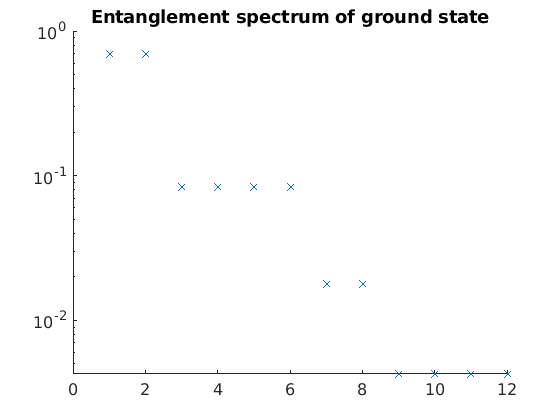

In [25]:
[~, S, ~] = tsvd(C); % singular values of center matrix give entanglement spectrum
S = diag(double(S));
scatter(1:D, S, 'Marker', 'x')
set(gca, 'YScale', 'log')
title('Entanglement spectrum of ground state')

We can clearly see that the entanglement spectrum consists of degenerate groups, which reflects an underlying symmetry in the ground state of the spin-1 Heisenberg antiferromagnet.

## 5 Elementary excitations

### Quasiparticle ansatz

The methods described above can be extended beyond computing the ground state. We briefly discuss how one can also study excitations on top of a given ground state. For this, we introduce the MPS quasiparticle ansatz, given by

<center><img src="img/excitation.svg" alt="quasiparticle ansatz"></center>

This ansatz cosists of defining a new state by changing one $A$ tensor of the ground state at site $n$ and taking a momentum superposition.

Before describing how to optimize the tensor $B$, it is worthwile to investigate the corresponding variational space in a bit more detail. First, we note that this excitation ansatz can be interpreted as nothing more than a boosted version of a tangent vector to the MPS manifold. In particular, this means that we will be able to apply all kinds of useful tricks and manipulations to the tensor $B$ (cfr. the [lecture notes](https://doi.org/10.21468/SciPostPhysLectNotes.7) for an introduction to tangent vectors and their properties). For example, we can see that $B$ has gauge degrees of freedom, as the corresponding excited state is invariant under an additive gauge transformation of the form

<center><img src="img/gaugeExcitation.svg" alt="gauge transform excitation"></center>

where $Y$ is an arbitrary $D \times D$ matrix. This gauge freedom can be eliminated, thereby removing the zero modes in the variational subspace, by imposing a *left gauge-fixing condition*

<center><img src="img/gaugeFix.svg" alt="gauge fix"></center>

If we parametrize the tensor $B$ as

<center><img src="img/VlX.svg" alt="VlX"></center>

where $V_L$ is the $ D \times d \times D(d-1)$ tensor corresponding to the $D(d-1)$-dimensional null space of $A_L$ satisfying

<center><img src="img/Vl.svg" alt="Vl"></center>

then the gauge condition is automatically satisfied. In particular, this fixing of the gauge freedom ensures that the excitation is orthogonal to the ground state,

<center><img src="img/excitationOrth.svg" alt="excitationOrth"></center>

In this form, we have put forward an ansatz for an excited state characterized by a single $D(d-1) \times D$ matrix $X$ such that

1. All gauge degrees of freedom are fixed.
2. All zero modes in the variational subspace are removed.
3. Calculating the norm becomes straightforward.
4. The excitation is orthogonal to the ground state.

### Solving the eigenvalue problem

Having introduced an excitation  ansatz which has all the right properties and is defined in terms of a single matrix $X$, all that is left to do is to minimize the energy function,

$$  \min_{X} \frac{\left \langle \Phi_p(X) \middle | H  \middle | \Phi_p(X) \right \rangle}{\left \langle \Phi_p(X) \middle | \Phi_p(X)  \right \rangle}. $$

As both the numerator and the denominator are quadratic functions of the variational parameters $X$, this optimization problem reduces to solving a generalized eigenvalue problem

$$ H_{\text{eff}}(q) X = \omega N_{\text{eff}}(q) X, $$

where the effective energy and normalization matrices are defined as

$$
\begin{align}
& 2\pi\delta(p-p') (\boldsymbol{X'})^\dagger H_{\text{eff}}(q) \boldsymbol{X} = \left \langle \Phi_{p'}(X') \middle | H  \middle | \Phi_p(X) \right \rangle \\
& 2\pi\delta(p-p') (\boldsymbol{X'})^\dagger N_{\text{eff}}(q) \boldsymbol{X} = \left \langle \Phi_{p'}(X') \middle | \Phi_p(X) \right \rangle,
\end{align}
$$

and $\boldsymbol{X}$ denotes a vectorized version of the matrix $X$. Since the overlap between two excited states is of the simple Euclidean form (cfr. the [lecture notes](https://doi.org/10.21468/SciPostPhysLectNotes.7)), the effective normalization matrix reduces to the unit matrix, and we are left with an ordinary eigenvalue problem.

To solve this eigenvalue problem, we need to find an expression for $H_{\text{eff}}$, or rather of the action thereof on a trial vector $\boldsymbol{Y}$. In order to find this action we first transform the vector $\boldsymbol{X}$ into a tensor $B$ by contracting its corresponding matrix with the right leg of $V_L$, and then compute all different contributions that pop up in a matrix element of the form $\left \langle \Phi_p(B') \middle | H  \middle | \Phi_p(B) \right \rangle$. This procedure is similar to what we have done when computing the gradient above, where we now need to take into account all different positions of the nearest-neighbor operator $h$ of the Hamiltonian, the input tensor $B$ and the output. Though slightly more involved than before, we can again define the following partion contractions

<center><img src="img/LhMixed.svg" alt="LhMixed"></center>

<br>

<center><img src="img/RhMixed.svg" alt="RhMixed"></center>

<br>

<center><img src="img/LB.svg" alt="LB"></center>

<br>

<center><img src="img/RB.svg" alt="RB"></center>

<br>

<center><img src="img/L1.svg" alt="L1"></center>

<br>

<center><img src="img/R1.svg" alt="R1"></center>

Using these partial contractions, we find the action of the effective energy matrix on a given input tensor $B(Y)$ as

<center><img src="img/HeffExcitation.svg" alt="HeffExcitation"></center>

In the last step, we need the action of $H_{\text{eff}}(p)$ on the vector $\boldsymbol{Y}$, so we need to perform a last contraction

<center><img src="img/quasi_inveff.svg" alt="quasi_inveff"></center>

The total procedure is implemented in the routine `quasiParticle`.

In [26]:
%%file quasiParticle.m
function [x, e] = quasiParticle(h, Al, Ar, C, Ac, p, num, tol)

    % renormalize hamiltonian and find left and right environments
    hTilde = reducedHamMixed(h, Ac, Ar);
    Lh = LhMixed(hTilde, Al, C, tol);
    Rh = RhMixed(hTilde, Ar, C, tol);
    
    % find reduced parametrization
    Vl = leftnull(Al, [1, 2], 3);
    
    % solve eigenvalue problem
    x0 = Vl.randnc([Vl.dims(3), Al.dims(3)], 'Rank', [1, 1]);
    [x, e] = eigsolve(@ApplyHeff, x0, num, 'smallestreal', 'Tol', tol);
    e = diag(e);
    
    function y = ApplyHeff(x)
        
        B = contract(Vl, [-1, -2, 1], x, [1, -3], 'Rank', Al.rank);
        
        % right disconnected
        right = contract(B, [-1, 2, 1], conj(Ar), [-2, 2, 1], 'Rank', [1, 1]);
        [right, ~] = linsolve(@(x) ApplyELR(x, p), right, [], [], [], 'Tol', tol);
        
        % left disconnected
        left =  contract(Lh, [1, 2], B, [2, 3, -2], conj(Al), [1, 3, -1]) + ...
                contract(Al, [1, 2, 4], B,[4, 5, -2], conj(Al),[1, 3, 6], conj(Al), [6, 7, -1], hTilde, [3, 7, 2, 5]) + ...
                exp(-1i*p) * contract(B, [1, 2, 4], Ar, [4, 5, -2], conj(Al), [1, 3, 6], conj(Al), [6, 7, -1], hTilde, [3, 7, 2, 5]);
        left = repartition(left, [1, 1]);
        [left, ~] = linsolve(@(x) ApplyERL(x, p), left, [], [], [], 'Tol', tol);
        
        y = contract(B, [-1, 2, 1], Ar, [1, 3, 4], conj(Ar), [-3,5,4], hTilde, [-2, 5, 2, 3]) + ...
            exp(1i*p) * contract(Al, [-1, 2, 1], B, [1, 3, 4], conj(Ar), [-3, 5, 4], hTilde, [-2, 5, 2, 3]) + ...
            exp(-1i*p) * contract(B, [4,3,1], Ar, [1, 2, -3], conj(Al), [4, 5, -1], hTilde, [5, -2, 3, 2]) + ...
            contract(Al, [4, 3, 1], B, [1, 2, -3], conj(Al), [4, 5, -1], hTilde,[5,-2,3,2]) + ...
            exp(1i*p) * contract(Al, [1, 2, 4], Al, [4, 5, 6], conj(Al), [1, 3, -1], right, [6, -3], hTilde, [3, -2, 2, 5]) + ...
            exp(2*1i*p) * contract(Al, [-1, 6, 5], Al, [5, 3, 2], conj(Ar), [-3, 4, 1],right, [2, 1], hTilde, [-2, 4, 6, 3]) + ...
            contract(Lh, [-1, 1], B, [1, -2, -3]) + ...
            contract(B, [-1,-2,1], Rh, [1, -3]) + ...
            exp(-1i*p) * contract(left, [-1,1], Ar,[1,-2,-3]) + ...
            exp(+1i*p) * contract(Lh, [-1,1], Al, [1, -2, 2], right, [2, -3]);
            
        y = contract(y, [1, 2, -2], conj(Vl), [1, 2, -1], 'Rank', x.rank);
        
        function y = ApplyELR(x, p)
            overlap = contract(conj(C), [1, 2], x, [1, 2]);
            y = contract(Al, [-1, 3, 1], conj(Ar), [-2, 3, 2], x, [1, 2], 'Rank', x.rank);
            y = x - exp(1i*p) * (y - overlap * C);
        end

        function y = ApplyERL(x, p)
            overlap = contract(conj(C), [1, 2], x, [1, 2]);
            y = contract(x, [1, 2], Ar, [2, 3, -2], conj(Al), [1, 3, -1], 'Rank', x.rank);
            y = x - exp(1i*p) * (y - overlap * C);
        end
        
    end
    
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/quasiParticle.m'.


We can use this to compute the Haldane gap on top of the ground state of the spin-1 Heisenberg antiferromagnet we have just obtained using VUMPS.

In [27]:
p = pi;
num = 3;
tol = 1e-12;
[x, e] = quasiParticle(h, Al, Ar, C, Ac, p, num, tol);
fprintf('First triplet: %s\n', join(string(real(e)), ', '));

First triplet: 0.40938, 0.40938, 0.40938
